In [21]:
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

## Image Augmentation

In [2]:
train_url = "C:\\Users\\ADMIN\\Desktop\\WasteClassification\\DATASET\\TRAIN"
test_url = "C:\\Users\\ADMIN\\Desktop\\WasteClassification\\DATASET\\TEST"

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 64
img_size = (128, 128)

train_set = train_datagen.flow_from_directory(train_url, 
                                              class_mode='binary',
                                              batch_size = batch_size,
                                              target_size=img_size)

test_set = val_datagen.flow_from_directory(test_url, 
                                           class_mode = 'binary',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 22564 images belonging to 2 classes.
Found 2514 images belonging to 2 classes.


## Base Model

In [6]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128,128,3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model', save_best_only=True)

hist = model1.fit(train_set, validation_data=test_set, epochs=20, callbacks=[early_stopping, checkpoint])

## Transfer Learning with MobileNetV2

In [9]:
baseModel = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), weights='imagenet',
                                           include_top=False, classes=1)

for layers in baseModel.layers:
    layers.trainable=False

In [13]:
model = tf.keras.models.Sequential([
    baseModel,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=20
callbacks = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_4 (Dropout)         (None, 20480)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                655392    
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                      

In [14]:
history = model.fit(train_set, validation_data=test_set, epochs=epochs, callbacks=[callbacks])

Epoch 1/20
353/353 [==============================] - 354s 995ms/step - loss: 0.5727 - accuracy: 0.7063 - val_loss: 0.3743 - val_accuracy: 0.8652
Epoch 2/20
353/353 [==============================] - 297s 841ms/step - loss: 0.4150 - accuracy: 0.8085 - val_loss: 0.3167 - val_accuracy: 0.8755
Epoch 3/20
353/353 [==============================] - 180s 509ms/step - loss: 0.3769 - accuracy: 0.8323 - val_loss: 0.2977 - val_accuracy: 0.8739
Epoch 4/20
353/353 [==============================] - 170s 482ms/step - loss: 0.3546 - accuracy: 0.8487 - val_loss: 0.2783 - val_accuracy: 0.8978
Epoch 5/20
353/353 [==============================] - 169s 478ms/step - loss: 0.3321 - accuracy: 0.8606 - val_loss: 0.2833 - val_accuracy: 0.8942
Epoch 6/20
353/353 [==============================] - 177s 501ms/step - loss: 0.3171 - accuracy: 0.8681 - val_loss: 0.2582 - val_accuracy: 0.8982
Epoch 7/20
353/353 [==============================] - 174s 493ms/step - loss: 0.3111 - accuracy: 0.8723 - val_loss: 0.2579 -

#### Save model

In [15]:
model.save("waste_classifier")

INFO:tensorflow:Assets written to: waste_classifier\assets


INFO:tensorflow:Assets written to: waste_classifier\assets


#### Training process evaluating

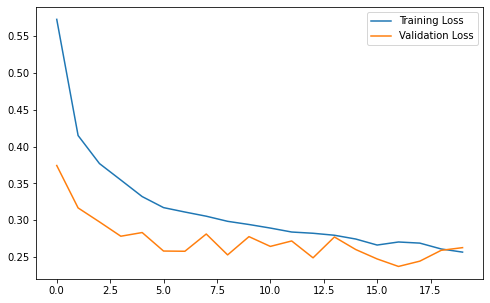

In [18]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

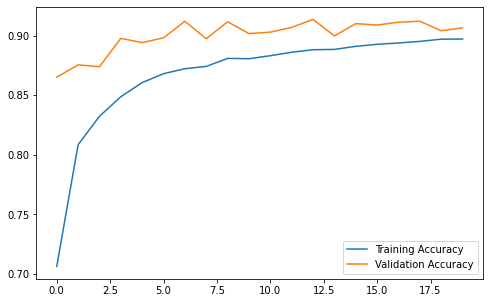

In [20]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])

In [27]:
train_set = val_datagen.flow_from_directory(train_url, 
                                           class_mode = 'binary',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 22564 images belonging to 2 classes.


In [28]:
model.evaluate(train_set)
model.evaluate(test_set)

40/40 [==============================] - 13s 328ms/step - loss: 0.2628 - accuracy: 0.9065


#### Determining Threshold 

In [22]:
def evaluate(y, y_pred, p=0.5):
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix(y, y_pred >= p), annot=True)
    print(classification_report(y, y_pred >= p, digits=5))

def plot_roc_auc(y, y_pred):
    fpr, tpr, threshold = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    
    #create ROC curve
    plt.figure(figsize=(10,6))
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
    return threshold[ix]

40/40 [==============================] - 14s 340ms/step


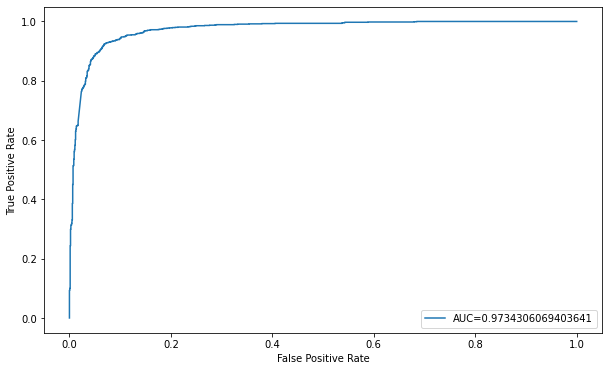

Best Threshold=0.342975, G-Mean=0.928


In [33]:
y_pred = model.predict(test_set)
THRESHOLD = plot_roc_auc(test_set.classes, y_pred)

## Final Evaluation Result

              precision    recall  f1-score   support

           0    0.93952   0.93148   0.93548      1401
           1    0.91467   0.92453   0.91957      1113

    accuracy                        0.92840      2514
   macro avg    0.92710   0.92800   0.92753      2514
weighted avg    0.92852   0.92840   0.92844      2514



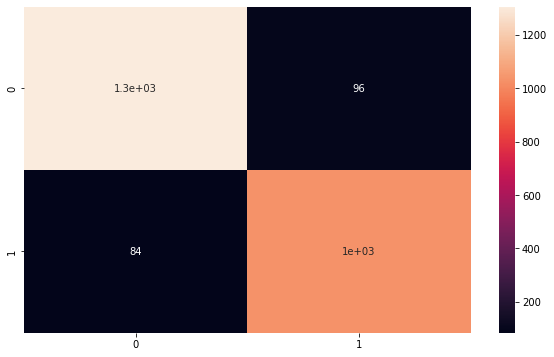

In [34]:
evaluate(test_set.classes, y_pred, p=THRESHOLD)